In [2]:
import torch
import torch.nn.functional as F
import pandas as pd
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import os


from bin_cp.helpers.storage import load_smooth_prediction
from bin_cp.helpers.tensor import get_smooth_scores, get_cal_mask, quantization_pdf, bound_tensor
from bin_cp.robust.confidence import bernstein_bound, dkw_cdf
from bin_cp.robust.confidence import clopper_pearson_lower
from bin_cp.robust.bounds import mean_bounds_l2, CDF_bounds_l2

from bin_cp.cp.core import ConformalClassifier as CP
from bin_cp.cp.scores import APSScore, TPSScore, LogitScore

from bin_cp.methods.robust_cp import RobustCP, VanillaSmoothCP
from bin_cp.methods.cas import CAS
from bin_cp.methods.bincp import BinCP
from bin_cp.methods.rcp_one import RCP1
# from qrcp.methods.binary import QRCPThresholds
import time

from tqdm import tqdm

In [3]:
#region primary configs of the experiment

output_dir = "../../results/"

dataset_name = "cifar10"
model_sigma = 0.25
n_classes=10
n_datapoints = 2048
smoothing_sigma = 0.25
n_samples = 10000
n_trial_samples = 50

score_method = "TPS"
calibration_budget = 0.1
n_iterations = 100

confidence = 0.999
coverage_range = [0.85, 0.9, 0.95]
# coverage_range = [0.9]
r_range = [0.06, 0.12, 0.18, 0.25, 0.37, 0.5, 0.75]
# r_range = [0.12,  0.25, 0.5, ]

#endregion

In [4]:
output_dir = pathlib.Path(output_dir)/dataset_name
output_dir.mkdir(parents=True, exist_ok=True)

In [5]:
models_dir = pathlib.Path("/home/c01saha/CISPA-projects/agrauq-2024/Robust_CP/models/")
dataset_dir = pathlib.Path("/home/c01saha/CISPA-projects/agrauq-2024/datasets/")
logits_dir = pathlib.Path("/home/c01saha/CISPA-projects/agrauq-2024/Robust_CP/logits/")

In [6]:
#region loding smooth logit predictions
if n_samples < n_trial_samples:
    print(f"Number of trial samples is set to {n_trial_samples} as it is smaller than the number of samples.")
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

try:
    smooth_prediction = load_smooth_prediction(dataset_name=dataset_name,
        model_sigma=model_sigma,
        n_datapoints=n_datapoints,
        smoothing_sigma=smoothing_sigma,
        n_samples=n_samples,
        models_dir=models_dir,
        dataset_dir=dataset_dir,
        logits_dir=logits_dir,)
    n_classes = 10 if dataset_name == "cifar10" else None
except FileNotFoundError as e:
    print("Smooth predictions not found, you can generate them using bin/smooth_logits_clean.py")
    print("Full description of the error: ", e)
#endregion

# region computing the conformal scores.
score_pipeline = [
    TPSScore(softmax=True) if score_method == "TPS" else APSScore(softmax=True)] # defining the score function
cp = CP(score_pipeline=score_pipeline, coverage_guarantee=0.9) # the guarantee can vary later by cp.coverage_guarantee
smooth_scores = get_smooth_scores(smooth_prediction.logits, cp, mean=False)
smooth_scores = smooth_scores[:, :, :n_trial_samples]
y_true_mask = F.one_hot(smooth_prediction.y_true, num_classes=10).bool().to(device)
print(f"Loading {dataset_name} dataset with {n_datapoints} datapoints and {n_samples} samples: Score method: {score_method}")

Loading cifar10 dataset with 2048 datapoints and 10000 samples: Score method: TPS


In [49]:
result = []

for r in r_range:
    for coverage_guarantee in coverage_range:
        cal_mask = get_cal_mask(smooth_scores, calibration_budget)
        n_dcal = cal_mask.sum().item()

        cp_methods = {
            "CAS": CAS(smoothing_sigma=smoothing_sigma, confidence_level=confidence, n_dcal=n_dcal, n_classes=n_classes, nominal_coverage=coverage_guarantee, r=r),
            "BinCP": BinCP(smoothing_sigma=smoothing_sigma, confidence_level=confidence, n_dcal=n_dcal, n_classes=n_classes,
                        p_base=0.8, scheme="guass", nominal_coverage=coverage_guarantee, r=r),
            "RCP1": RCP1(smoothing_sigma=smoothing_sigma, n_dcal=n_dcal, n_classes=n_classes, nominal_coverage=coverage_guarantee, r=r),
        }

        for method_name, method in cp_methods.items():
            print(f"Pre-computing {method_name} for r={r} and coverage={coverage_guarantee}")
            method.pre_compute(smooth_scores, smooth_prediction.y_true)

        print(f"Running the experiment for r={r} and coverage={coverage_guarantee}")
        for iteration in tqdm(range(n_iterations)):
            cal_mask = get_cal_mask(smooth_scores, calibration_budget)
            eval_mask = ~cal_mask

            for method_name, method in cp_methods.items():
                threshold = method.calibrate_from_scores(smooth_scores[cal_mask], smooth_prediction.y_true[cal_mask])
                pred_set = method.predict_from_scores(smooth_scores[eval_mask], return_scores=False)
                covered = (pred_set)[torch.arange(pred_set.shape[0]), smooth_prediction.y_true[eval_mask]]
                set_size = pred_set.sum(dim=1)

                empirical_coverage = covered.float().mean().item()
                avg_set_size = set_size.float().mean().item()
                result.append({
                    "method": method_name,
                    "empirical_coverage": empirical_coverage,
                    "avg_set_size": avg_set_size,
                    "r": r,
                    "coverage_guarantee": coverage_guarantee,
                    "threshold": threshold,
                    "internal_coverage_level": method.internal_cp.coverage_guarantee,
                    "below_1": (set_size <= 1).float().mean().item(),
                    "below_3": (set_size <= 3).float().mean().item(),
                    "below_5": (set_size <= 5).float().mean().item(),
                    "below_1_coverage": covered[set_size <= 1].float().mean().item(),
                    "below_3_coverage": covered[set_size <= 3].float().mean().item(),
                    "below_5_coverage": covered[set_size <= 5].float().mean().item(),
                    "n_samples": n_trial_samples,
                })

Pre-computing CAS for r=0.06 and coverage=0.85


KeyboardInterrupt: 

In [18]:
n_dcal

400

In [19]:
result = pd.DataFrame(result)
result.to_csv(output_dir/f"results_l2-gauss_{dataset_name}_{score_method}_clean_r-0.0_samples-{n_trial_samples}.csv", index=False)
result.groupby(["coverage_guarantee", "r", "method"]).mean()

empirical_coverage  avg_set_size    threshold  \
coverage_guarantee r    method                                                  
0.85               0.01 BinCP             0.960557      2.197339     0.132138   
                        RCP1              0.907604      2.013370     0.051239   
                   0.02 BinCP             0.961146      2.211438     0.129489   
                        RCP1              0.909870      2.030068     0.048496   
                   0.03 BinCP             0.964667      2.302380     0.124594   
                        RCP1              0.912984      2.068604     0.046118   
                   0.06 BinCP             0.962828      2.259630     0.130365   
                        RCP1              0.914641      2.090589     0.044706   
                   0.12 BinCP             0.967979      2.387516     0.127961   
                        RCP1              0.938031      2.405318     0.026168   
                   0.25 BinCP             0.970880      2.479219     0.133008   
                        RCP1              0.972865      3.305516     0.006713   
                   0.50 BinCP             0.982484      2.979443     0.128194   
                        RCP1              1.000000     10.000000 -1000.000000   
0.90               0.01 BinCP             0.976188      2.654750     0.073737   
                        RCP1              0.903313      1.968578     0.054648   
                   0.02 BinCP             0.976510      2.670698     0.072179   
                        RCP1              0.906370      1.998464     0.051878   
                   0.03 BinCP             0.976229      2.660214     0.076940   
                        RCP1              0.905000      1.987182     0.052894   
                   0.06 BinCP             0.977911      2.732729     0.070975   
                        RCP1              0.918839      2.131693     0.041027   
                   0.12 BinCP             0.979661      2.799073     0.075216   
                        RCP1              0.935672      2.368802     0.027934   
                   0.25 BinCP             0.983073      2.980688     0.073165   
                        RCP1              0.975859      3.424203     0.005517   
                   0.50 BinCP             0.989719      3.520214     0.071110   
                        RCP1              1.000000     10.000000 -1000.000000   
0.95               0.01 BinCP             0.990714      3.627208     0.022619   
                        RCP1              0.907036      2.004719     0.051202   
                   0.02 BinCP             0.991224      3.634641     0.021266   
                        RCP1              0.909786      2.027750     0.048661   
                   0.03 BinCP             0.991042      3.656516     0.023195   
                        RCP1              0.909969      2.036245     0.048929   
                   0.06 BinCP             0.990589      3.573792     0.025189   
                        RCP1              0.917786      2.115953     0.041894   
                   0.12 BinCP             0.992302      3.806583     0.022307   
                        RCP1              0.933156      2.324313     0.029416   
                   0.25 BinCP             0.993583      4.012052     0.021254   
                        RCP1              0.969677      3.192912     0.008127   
                   0.50 BinCP             0.996172      4.528396     0.023129   
                        RCP1              1.000000     10.000000 -1000.000000   

                                internal_coverage_level   below_1   below_3  \
coverage_guarantee r    method                                                
0.85               0.01 BinCP                  0.851000  0.379021  0.838271   
                        RCP1                   0.902886  0.465031  0.868047   
                   0.02 BinCP                  0.851000  0.376229  0.834677   
                        RCP1                   0.905774  0.460073  0.864

In [ ]:
result.loc[result.coverage_guarantee == 0.9].groupby(["coverage_guarantee", "r", "method"]).mean()

empirical_coverage  avg_set_size    threshold  \
coverage_guarantee r    method                                                  
0.9                0.06 BinCP             0.982018      3.004753     0.048455   
                        CAS               1.000000     10.000000     0.040294   
                        RCP1              0.937306      2.241769     0.040818   
                   0.12 BinCP             0.987534      3.363360     0.051260   
                        CAS               1.000000     10.000000     0.033337   
                        RCP1              0.959614      2.734357     0.021940   
                   0.18 BinCP             0.994067      4.133172     0.047769   
                        CAS               1.000000     10.000000     0.021985   
                        RCP1              0.988149      4.228231     0.004688   
                   0.25 BinCP             1.000000     10.000000     0.047977   
                        CAS               1.000000     10.000000     0.014438   
                        RCP1              1.000000     10.000000 -1000.000000   
                   0.37 BinCP             1.000000     10.000000     0.046737   
                        CAS               1.000000     10.000000     0.006174   
                        RCP1              1.000000     10.000000 -1000.000000   
                   0.50 BinCP             1.000000     10.000000     0.046628   
                        CAS               1.000000     10.000000     0.002054   
                        RCP1              1.000000     10.000000 -1000.000000   
                   0.75 BinCP             1.000000     10.000000     0.050639   
                        CAS               1.000000     10.000000     0.000146   
                        RCP1              1.000000     10.000000 -1000.000000   

                                internal_coverage_level   below_1   below_3  \
coverage_guarantee r    method                                                
0.9                0.06 BinCP                  0.901000  0.277895  0.653406   
                        CAS                    0.901000  0.000000  0.000000   
                        RCP1                   0.935939  0.434870  0.811012   
                   0.12 BinCP                  0.901000  0.224728  0.578765   
                        CAS                    0.901000  0.000000  0.000000   
                        RCP1                   0.960927  0.358343  0.709654   
                   0.18 BinCP                  0.901000  0.145750  0.439771   
                        CAS                    0.901000  0.000000  0.000000   
                        RCP1                   0.977334  0.208815  0.467138   
                   0.25 BinCP                  0.901000  0.000000  0.000000   
                        CAS                    0.901000  0.000000  0.000000   
                        RCP1                   0.988742  0.000000  0.000000   
                   0.37 BinCP                  0.901000  0.000000  0.000000   
                        CAS                    0.901000  0.000000  0.000000   
                        RCP1                   0.997124  0.000000  0.000000   
                   0.50 BinCP                  0.901000  0.000000  0.000000   
                        CAS                    0.901000  0.000000  0.000000   
                        RCP1                   0.999484  0.000000  0.000000   
                   0.75 BinCP                  0.901000  0.000000  0.000000   
                        CAS                    0.901000  0.000000  0.000000   
                        RCP1                   0.999991  0.000000  0.000000   

                                 below_5  below_1_coverage  below_3_coverage  \
coverage_guarantee r    method                                                 
0.9                0.06 BinCP   0.880447          0.986425          0.984238   
                        CAS     0.000000               NaN               NaN   
                        RCP1  

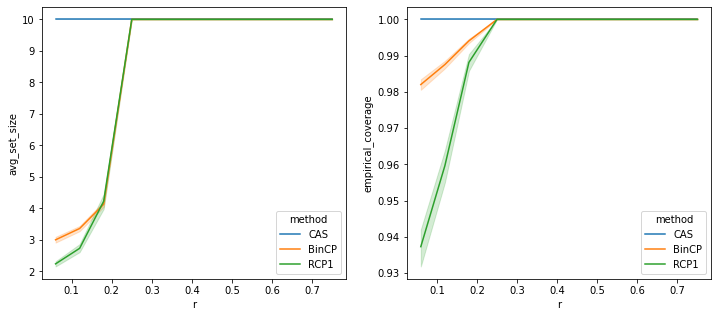

In [ ]:
f, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.lineplot(data=result.loc[result["coverage_guarantee"] == 0.9], x="r", y="avg_set_size", hue="method", ax=axs[0])
sns.lineplot(data=result.loc[result["coverage_guarantee"] == 0.9], x="r", y="empirical_coverage", hue="method", ax=axs[1])
plt.show()

In [24]:
from bin_cp.robust.noises import Gaussian, Laplace, Uniform

r_range = [0.01, 0.02, 0.03, 0.06, 0.12, 0.25, 0.5]
coverage_range = [0.85, 0.9, 0.95]
n_iterations = 20
n_trial_samples = 60
calibration_budget = 0.04

smoothing_sigma=1
scheme = "uniform-l1"
smoothing_sigma_map = lambda v: (f"{v:.2f}").replace(".", "")

smooth_logits = torch.tensor(np.load(f"../bin_cp/precomputed/cifar_{scheme.split('-')[0]}_{smoothing_sigma_map(smoothing_sigma)}/logits.npy"))
print("logits shape: ", smooth_logits.shape)
smooth_scores = get_smooth_scores(smooth_logits, cp, mean=False)
smooth_scores = smooth_scores[:, :, :n_trial_samples].to(device)
print("scores shape: ", smooth_scores.shape)
y_true = torch.tensor(np.load(f"../bin_cp/precomputed/cifar_{scheme.split('-')[0]}_{smoothing_sigma_map(smoothing_sigma)}/labels.npy")).long().to(device)
y_true_mask = F.one_hot(y_true, num_classes=10).bool().to(device)
f"../bin_cp/precomputed/cifar_{scheme.split('-')[0]}_{smoothing_sigma_map(smoothing_sigma)}/logits.npy"

logits shape:  torch.Size([10000, 512, 10])
scores shape:  torch.Size([10000, 10, 60])


'../bin_cp/precomputed/cifar_uniform_100/logits.npy'

In [25]:
result = []


for r in r_range:
    for coverage_guarantee in coverage_range:
        cal_mask = get_cal_mask(smooth_scores, calibration_budget)
        n_dcal = cal_mask.sum().item()

        p_lower = RCP1.compute_threat_p(coverage_guarantee, r, sigma=smoothing_sigma)
        p_upper = RCP1.compute_threat_p(0.2, r, sigma=smoothing_sigma, scheme=scheme, type="upper")
        
        print(p_lower, p_upper)

        cp_methods = {
            "BinCP": BinCP(smoothing_sigma=smoothing_sigma, confidence_level=confidence, n_dcal=n_dcal, n_classes=n_classes,
                                p_base=0.6, scheme=scheme, nominal_coverage=coverage_guarantee, r=r),
            "RCP1": RCP1(smoothing_sigma=smoothing_sigma, n_dcal=n_dcal, n_classes=n_classes, 
                                scheme=scheme, schnominal_coverage=coverage_guarantee, r=r),
        }

        for method_name, method in cp_methods.items():
            print(f"Pre-computing {method_name} for r={r} and coverage={coverage_guarantee}")
            method.pre_compute(smooth_scores, y_true)

        print(f"Running the experiment for r={r} and coverage={coverage_guarantee}")
        for iteration in tqdm(range(n_iterations)):
            cal_mask = get_cal_mask(smooth_scores, calibration_budget)
            eval_mask = ~cal_mask

            for method_name, method in cp_methods.items():
                threshold = method.calibrate_from_scores(smooth_scores[cal_mask], y_true[cal_mask])
                pred_set = method.predict_from_scores(smooth_scores[eval_mask], return_scores=False)
                covered = (pred_set)[torch.arange(pred_set.shape[0]), y_true[eval_mask]]
                set_size = pred_set.sum(dim=1)

                empirical_coverage = covered.float().mean().item()
                avg_set_size = set_size.float().mean().item()
                result.append({
                    "method": method_name,
                    "empirical_coverage": empirical_coverage,
                    "avg_set_size": avg_set_size,
                    "r": r,
                    "coverage_guarantee": coverage_guarantee,
                    "threshold": threshold,
                    "internal_coverage_level": method.internal_cp.coverage_guarantee,
                    "below_1": (set_size <= 1).float().mean().item(),
                    "below_3": (set_size <= 3).float().mean().item(),
                    "below_5": (set_size <= 5).float().mean().item(),
                    "below_1_coverage": covered[set_size <= 1].float().mean().item(),
                    "below_3_coverage": covered[set_size <= 3].float().mean().item(),
                    "below_5_coverage": covered[set_size <= 5].float().mean().item(),
                    "n_samples": n_trial_samples,
                })


0.8476563268816574 0.20288753509521484
Pre-computing BinCP for r=0.01 and coverage=0.85


/home/c01saha/CISPA-home/projects/quantilzed-cp-certificate/BinCP/bin_cp/robust/robust_bounds.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_max = certified_radius(1 - torch.tensor(p))
/home/c01saha/CISPA-home/projects/quantilzed-cp-certificate/BinCP/bin_cp/robust/robust_bounds.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_max = certified_radius(1 - torch.tensor(p))


Pre-computing RCP1 for r=0.01 and coverage=0.85
Running the experiment for r=0.01 and coverage=0.85


100%|██████████| 20/20 [00:05<00:00,  3.76it/s]


0.8982337525111341 0.20288753509521484
Pre-computing BinCP for r=0.01 and coverage=0.9
Pre-computing RCP1 for r=0.01 and coverage=0.9
Running the experiment for r=0.01 and coverage=0.9


100%|██████████| 20/20 [00:05<00:00,  3.62it/s]


0.9489601321489094 0.20288753509521484
Pre-computing BinCP for r=0.01 and coverage=0.95
Pre-computing RCP1 for r=0.01 and coverage=0.95
Running the experiment for r=0.01 and coverage=0.95


100%|██████████| 20/20 [00:05<00:00,  3.52it/s]


0.845288473838266 0.20577335357666016
Pre-computing BinCP for r=0.02 and coverage=0.85
Pre-computing RCP1 for r=0.02 and coverage=0.85
Running the experiment for r=0.02 and coverage=0.85


100%|██████████| 20/20 [00:05<00:00,  3.74it/s]


0.8964449030698107 0.20577335357666016
Pre-computing BinCP for r=0.02 and coverage=0.9
Pre-computing RCP1 for r=0.02 and coverage=0.9
Running the experiment for r=0.02 and coverage=0.9


100%|██████████| 20/20 [00:05<00:00,  3.68it/s]


0.9479031243989937 0.20577335357666016
Pre-computing BinCP for r=0.02 and coverage=0.95
Pre-computing RCP1 for r=0.02 and coverage=0.95
Running the experiment for r=0.02 and coverage=0.95


100%|██████████| 20/20 [00:05<00:00,  3.54it/s]


0.8428964306172543 0.20866107940673828
Pre-computing BinCP for r=0.03 and coverage=0.85
Pre-computing RCP1 for r=0.03 and coverage=0.85
Running the experiment for r=0.03 and coverage=0.85


100%|██████████| 20/20 [00:05<00:00,  3.74it/s]


0.8946333436115088 0.20866107940673828
Pre-computing BinCP for r=0.03 and coverage=0.9
Pre-computing RCP1 for r=0.03 and coverage=0.9
Running the experiment for r=0.03 and coverage=0.9


100%|██████████| 20/20 [00:05<00:00,  3.67it/s]


0.9468288016740543 0.20866107940673828
Pre-computing BinCP for r=0.03 and coverage=0.95
Pre-computing RCP1 for r=0.03 and coverage=0.95
Running the experiment for r=0.03 and coverage=0.95


100%|██████████| 20/20 [00:05<00:00,  3.54it/s]


0.8355751290273334 0.21732044219970703
Pre-computing BinCP for r=0.06 and coverage=0.85
Pre-computing RCP1 for r=0.06 and coverage=0.85
Running the experiment for r=0.06 and coverage=0.85


100%|██████████| 20/20 [00:05<00:00,  3.76it/s]


0.8890613729015364 0.21732044219970703
Pre-computing BinCP for r=0.06 and coverage=0.9
Pre-computing RCP1 for r=0.06 and coverage=0.9
Running the experiment for r=0.06 and coverage=0.9


100%|██████████| 20/20 [00:05<00:00,  3.67it/s]


0.9435002026136218 0.21732044219970703
Pre-computing BinCP for r=0.06 and coverage=0.95
Pre-computing RCP1 for r=0.06 and coverage=0.95
Running the experiment for r=0.06 and coverage=0.95


100%|██████████| 20/20 [00:05<00:00,  3.54it/s]


0.820280185301628 0.23464107513427734
Pre-computing BinCP for r=0.12 and coverage=0.85
Pre-computing RCP1 for r=0.12 and coverage=0.85
Running the experiment for r=0.12 and coverage=0.85


100%|██████████| 20/20 [00:05<00:00,  3.75it/s]


0.8772911671046237 0.23464107513427734
Pre-computing BinCP for r=0.12 and coverage=0.9
Pre-computing RCP1 for r=0.12 and coverage=0.9
Running the experiment for r=0.12 and coverage=0.9


100%|██████████| 20/20 [00:05<00:00,  3.67it/s]


0.9363521947096058 0.23464107513427734
Pre-computing BinCP for r=0.12 and coverage=0.95
Pre-computing RCP1 for r=0.12 and coverage=0.95
Running the experiment for r=0.12 and coverage=0.95


100%|██████████| 20/20 [00:05<00:00,  3.57it/s]


0.7841931856963938 0.2721681594848633
Pre-computing BinCP for r=0.25 and coverage=0.85
Pre-computing RCP1 for r=0.25 and coverage=0.85
Running the experiment for r=0.25 and coverage=0.85


100%|██████████| 20/20 [00:05<00:00,  3.75it/s]


0.8488588800142299 0.2721681594848633
Pre-computing BinCP for r=0.25 and coverage=0.9
Pre-computing RCP1 for r=0.25 and coverage=0.9
Running the experiment for r=0.25 and coverage=0.9


100%|██████████| 20/20 [00:05<00:00,  3.67it/s]


0.9184700082248818 0.2721681594848633
Pre-computing BinCP for r=0.25 and coverage=0.95
Pre-computing RCP1 for r=0.25 and coverage=0.95
Running the experiment for r=0.25 and coverage=0.95


100%|██████████| 20/20 [00:05<00:00,  3.55it/s]


0.7041704698190174 0.34433841705322266
Pre-computing BinCP for r=0.5 and coverage=0.85
Pre-computing RCP1 for r=0.5 and coverage=0.85
Running the experiment for r=0.5 and coverage=0.85


100%|██████████| 20/20 [00:05<00:00,  3.77it/s]


0.7827609195726948 0.34433841705322266
Pre-computing BinCP for r=0.5 and coverage=0.9
Pre-computing RCP1 for r=0.5 and coverage=0.9
Running the experiment for r=0.5 and coverage=0.9


100%|██████████| 20/20 [00:05<00:00,  3.63it/s]


0.8738651018065696 0.34433841705322266
Pre-computing BinCP for r=0.5 and coverage=0.95
Pre-computing RCP1 for r=0.5 and coverage=0.95
Running the experiment for r=0.5 and coverage=0.95


100%|██████████| 20/20 [00:05<00:00,  3.52it/s]


In [26]:
result = pd.DataFrame(result).fillna(0)
result.to_csv(output_dir/f"results_{scheme}_{dataset_name}_{score_method}_clean_r-0.0_samples-{n_trial_samples}_sigma-{smoothing_sigma}.csv", index=False)
result.groupby(["coverage_guarantee", "r", "method"]).mean()

empirical_coverage  avg_set_size    threshold  \
coverage_guarantee r    method                                                  
0.85               0.01 BinCP             0.981370      2.974089     0.135680   
                        RCP1              0.900359      1.953318     0.058952   
                   0.02 BinCP             0.982438      3.032432     0.127309   
                        RCP1              0.909391      2.028229     0.049331   
                   0.03 BinCP             0.982318      3.023427     0.129895   
                        RCP1              0.910313      2.045328     0.048290   
                   0.06 BinCP             0.982406      3.026323     0.127595   
                        RCP1              0.919604      2.138760     0.040518   
                   0.12 BinCP             0.986938      3.376844     0.122916   
                        RCP1              0.937396      2.387729     0.026313   
                   0.25 BinCP             0.991568      3.976797     0.122202   
                        RCP1              0.977885      3.514719     0.004795   
                   0.50 BinCP             1.000000     10.000000     0.126311   
                        RCP1              1.000000     10.000000 -1000.000000   
0.90               0.01 BinCP             0.989531      3.561922     0.071357   
                        RCP1              0.906891      2.009167     0.051709   
                   0.02 BinCP             0.989688      3.569802     0.070932   
                        RCP1              0.911375      2.051401     0.047596   
                   0.03 BinCP             0.989724      3.573818     0.070785   
                        RCP1              0.909401      2.036438     0.049811   
                   0.06 BinCP             0.990417      3.665162     0.064867   
                        RCP1              0.917974      2.133771     0.042518   
                   0.12 BinCP             0.991969      3.938240     0.067859   
                        RCP1              0.937401      2.388458     0.026440   
                   0.25 BinCP             0.995115      4.543646     0.067417   
                        RCP1              0.972594      3.290787     0.006851   
                   0.50 BinCP             1.000000     10.000000     0.071013   
                        RCP1              1.000000     10.000000 -1000.000000   
0.95               0.01 BinCP             0.995854      4.525406     0.024742   
                        RCP1              0.902531      1.967167     0.056276   
                   0.02 BinCP             0.995682      4.458120     0.025857   
                        RCP1              0.905229      1.988130     0.053624   
                   0.03 BinCP             0.995859      4.505682     0.024844   
                        RCP1              0.910234      2.037271     0.048166   
                   0.06 BinCP             0.996073      4.551167     0.023656   
                        RCP1              0.919604      2.134859     0.040661   
                   0.12 BinCP             0.996281      4.704615     0.029092   
                        RCP1              0.930750      2.282984     0.031327   
                   0.25 BinCP             0.997818      5.459130     0.025020   
                        RCP1              0.972818      3.302677     0.006755   
                   0.50 BinCP             1.000000     10.000000     0.021182   
                        RCP1              1.000000     10.000000 -1000.000000   

                                internal_coverage_level   below_1   below_3  \
coverage_guarantee r    method                                                
0.85               0.01 BinCP                  0.851000  0.240563  0.651313   
                        RCP1                   0.902886  0.480984  0.882474   
                   0.02 BinCP                  0.851000  0.234328  0.638115   
                        RCP1                   0.905774  0.461203  0.864

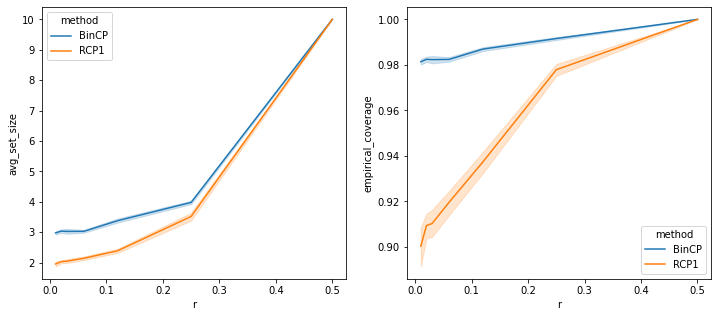

In [27]:
f, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.lineplot(data=result.loc[result["coverage_guarantee"] == 0.85], x="r", y="avg_set_size", hue="method", ax=axs[0])
sns.lineplot(data=result.loc[result["coverage_guarantee"] == 0.85], x="r", y="empirical_coverage", hue="method", ax=axs[1])
plt.show()

In [14]:
r = 0.12

cal_mask = get_cal_mask(smooth_scores, calibration_budget)
n_dcal = cal_mask.sum().item()

p_trace = 0.6

p_upper = RCP1.compute_threat_p(p_trace, r, sigma=smoothing_sigma, scheme="laplace-l1", type="upper")
print("p_upper = ", p_upper)

cp_methods = {
    "BinCP": BinCP(smoothing_sigma=smoothing_sigma, confidence_level=confidence, n_dcal=n_dcal, n_classes=n_classes,
                        p_base=p_upper, scheme="laplace-l1", nominal_coverage=coverage_guarantee, r=r, error_correction=True),
    "RCP1": RCP1(smoothing_sigma=smoothing_sigma, n_dcal=n_dcal, n_classes=n_classes, 
                        scheme="laplace-l1", schnominal_coverage=coverage_guarantee, r=r),
}
cp_bincp = cp_methods[method_name]

print(f"Pre-computing {method_name} for r={r} and coverage={coverage_guarantee}")
cp_bincp.pre_compute(smooth_scores, y_true)

print(f"Running the experiment for r={r} and coverage={coverage_guarantee}")

cal_mask = get_cal_mask(smooth_scores, calibration_budget)
eval_mask = ~cal_mask

p_upper =  0.710972785949707
Pre-computing RCP1 for r=0.12 and coverage=0.95
Running the experiment for r=0.12 and coverage=0.95


/home/c01saha/CISPA-home/projects/quantilzed-cp-certificate/BinCP/bin_cp/robust/robust_bounds.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_max = certified_radius(1 - torch.tensor(p))


In [15]:
cp_bincp = cp_methods["BinCP"]
bin_cp_threshold = cp_bincp.calibrate_from_scores(smooth_scores[cal_mask], y_true[cal_mask])
pred_set = cp_bincp.predict_from_scores(smooth_scores[eval_mask], return_scores=False)

bincp_calib_scores = cp_bincp.compute_lower_bound_scores(smooth_scores[cal_mask], y_true[cal_mask])
bincp_calib_scores = bincp_calib_scores[torch.arange(bincp_calib_scores.shape[0]), y_true[cal_mask]]

covered = (pred_set)[torch.arange(pred_set.shape[0]), y_true[eval_mask]]
set_size = pred_set.sum(dim=1)

empirical_coverage = covered.float().mean().item()
avg_set_size = set_size.float().mean().item()
print("BINCP: ", empirical_coverage, avg_set_size, "threshold = ", bin_cp_threshold)

/home/c01saha/CISPA-home/projects/quantilzed-cp-certificate/BinCP/bin_cp/robust/robust_bounds.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_max = certified_radius(1 - torch.tensor(p))


BINCP:  0.9980208277702332 5.2344794273376465 threshold =  0.012859970934180044


In [16]:
cp_rcp1 = cp_methods["RCP1"]

rcp1_threshold = cp_rcp1.calibrate_from_scores(smooth_scores[cal_mask], y_true[cal_mask])
pred_set = cp_rcp1.predict_from_scores(smooth_scores[eval_mask], return_scores=False)

rcp1_calib_scores = cp_rcp1.compute_lower_bound_scores(smooth_scores[cal_mask], y_true[cal_mask])
rcp1_calib_scores = rcp1_calib_scores[torch.arange(rcp1_calib_scores.shape[0]), y_true[cal_mask]]

covered = (pred_set)[torch.arange(pred_set.shape[0]), y_true[eval_mask]]
set_size = pred_set.sum(dim=1)

empirical_coverage = covered.float().mean().item()
avg_set_size = set_size.float().mean().item()

print("RCP-1: ", empirical_coverage, avg_set_size, "threshold = ", rcp1_threshold)

RCP-1:  1.0 10.0 threshold =  -1000


In [17]:
smoothing_sigma

1

<AxesSubplot:xlabel='None', ylabel='None'>

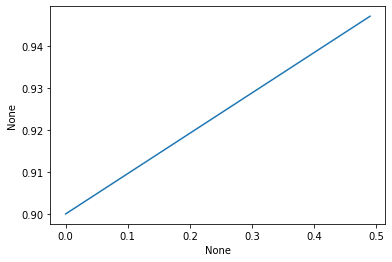

In [18]:
from bin_cp.robust.robust_bounds import compute_lower_p_from_r, compute_upper_p_from_r
from bin_cp.robust.noises import Laplace, Gaussian, get_dim, Uniform

r_vals = torch.arange(0, 0.5, 0.01)
uppers = torch.tensor([compute_upper_p_from_r(0.9, rr, Uniform(dim=get_dim("cifar"), sigma=3).certify_l1) for rr in r_vals])
sns.lineplot(x=r_vals, y=uppers)


0.9999990463256836

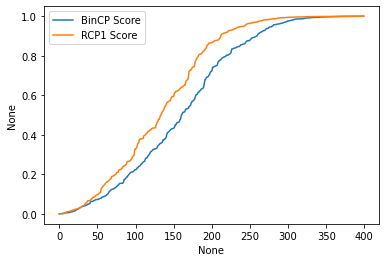

In [19]:
sns.lineplot(x=torch.arange(n_dcal), y=bincp_calib_scores.sort().values.cpu(), label="BinCP Score")
sns.lineplot(x=torch.arange(n_dcal), y=rcp1_calib_scores.sort().values.cpu(), label="RCP1 Score")

cp_rcp1.final_coverage

In [22]:
nn = 500
from statsmodels.stats.proportion import proportion_confint
proportion_confint(
        0.0 * nn, nn, alpha=0.001/(nn + 1), method="beta")

(0.0, 0.02725666331835489)

In [24]:
from scipy.stats import binomtest

binomtest(int(0.0 * nn), nn).proportion_ci((0.001) / (nn + 1)).high * 2

0.0027706757713205398